### !pip install albumentations

In [ ]:
# Installs the 'einops' library for easier array/tensor operations
pip install einops

# **Importing Libraries**

In [ ]:
# Import libraries
import torch  # Main PyTorch for deep learning
import torch.nn as nn  # For neural network layers
import torch.nn.functional as F  # For activation functions
import torch.optim as optim  # For training optimizers
from torch.utils.data import Dataset, DataLoader  # For loading data
import torchvision.transforms as transforms  # Basic image transforms
from torchvision.datasets import ImageFolder  # For image datasets

import numpy as np  # For math/array operations
import pandas as pd  # For data handling
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For nicer visualizations

from sklearn.model_selection import train_test_split  # To split train/test data
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix  # For model evaluation

from tqdm import tqdm  # For progress bars
import os  # For file/folder operations
import shutil  # For copying/moving files
import zipfile  # For working with zip files
from glob import glob  # For finding files

import albumentations as A  # For image augmentations
from albumentations.pytorch import ToTensorV2  # To convert images to tensors
from einops import rearrange  # For easy array reshaping

In [23]:
# Check PyTorch version and CPU
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: CPU")

PyTorch Version: 2.7.0+cpu
Device: CPU


# **Organizing  Dataset**

## 1. Defining paths

In [ ]:
# Path where the ZIP file is currently stored
zip_path = 'C:/Users/atish/01-Projects/COVID-19_Radiography_Dataset.zip'

# Where we'll extract the ZIP contents (main dataset folder)
dataset_path = 'C:/Users/atish/01-Projects/COVID-19_Radiography_Dataset'

# We'll create these folders later to organize train/test images
train_path = './train'    # Will store training images
test_path = './test'      # Will store testing images

In [27]:
os.path.exists(zip_path)

True

## 2. Unzip dataset

In [ ]:
# Check if dataset folder doesn't exist AND the zip file exists
if not os.path.exists(dataset_path) and os.path.exists(zip_path): 
    
    # Create the dataset folder (won't error if already exists)
    os.makedirs(dataset_path, exist_ok=True)  
    
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_path, 'r') as zip_ref: 
        
        # Extract all files from zip to the dataset folder's parent directory
        zip_ref.extractall(os.path.dirname(dataset_path)) 
    
    # Confirm extraction completed
    print(f" Dataset extracted to: {dataset_path}") 

# If dataset folder already exists or zip is missing
else:
    # Tell user where to find the existing dataset
    print(f" Dataset already available at: {dataset_path}")  

 Dataset already available at: C:/Users/atish/01-Projects/COVID-19_Radiography_Dataset


## 3. Collecting image paths and labels

In [ ]:
# Create a dictionary mapping each class name to a number (for ML labels)
class_map = {'COVID': 0, 'Viral Pneumonia': 1, 'Lung_Opacity': 2, 'Normal': 3}

# Initialize empty list to store image paths and their labels
data = []

# Loop through each class (COVID, Viral Pneumonia, etc.)
for class_name in class_map:
    
    # Create the full path to this class's "images" subfolder
    image_folder = os.path.join(dataset_path, class_name, 'images')
    
    # Find all PNG images in this folder using glob
    image_paths = glob(os.path.join(image_folder, '*.png'))
    
    # Add each image path with its class name to the data list
    data.extend([[img_path, class_name] for img_path in image_paths])

# Print the total number of images found across all classes
print(f" Total images found: {len(data)}")

 Total images found: 21165


## 4. Creating DataFrame and split

In [ ]:
# Create a pandas DataFrame to organize our image paths and their labels

df = pd.DataFrame(data, columns=['image_path', 'label'])

# Split the data into training (90%) and test sets (10%) while preserving:
# - The same class proportions in both sets (stratify=df['label'])

train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Print how many images are in each set
print(f" Train size: {len(train_df)}, Test size: {len(test_df)}")

 Train size: 19048, Test size: 2117


## 5. Creating train/test directories

In [ ]:
# Create train/test directories
for path in [train_path, test_path]:
    for class_name in class_map:
        os.makedirs(os.path.join(path, class_name), exist_ok=True)

## Copies training images to labeled folders and prints train/test image counts

In [ ]:


# Loop through each training image record
for _, row in train_df.iterrows():

    # Build destination path: train/label/filename
    dest = os.path.join(train_path, row['label'], os.path.basename(row['image_path']))

    # Copy image to organized folder structure
    shutil.copyfile(row['image_path'], dest)

# Print counts of training and test images
print(f"Train images: {len(train_df)}, Test images: {len(test_df)}")

Train images: 19048, Test images: 2117


# **Defining Data Loaders**

In [ ]:
#Resizes images to 128x128, applies random horizontal flip (50% chance) and normalization for training, only resize and normalization for testing, then converts both to PyTorch tensors.


In [ ]:
# Define transformations (128x128 for CPU efficiency)
train_transforms = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),#There is a 50% probability that the image will be flipped horizontally (mirrored left-to-right)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()#converts an image into a PyTorch tensor, a format required for PyTorch-based neural networks
])

## 1. Loading datasets

In [ ]:
# Loads training and test datasets using ImageFolder, applying the defined transformations to convert images to PyTorch tensors.
train_dataset = ImageFolder(train_path, transform=lambda x: train_transforms(image=np.array(x))['image'])
test_dataset = ImageFolder(test_path, transform=lambda x: test_transforms(image=np.array(x))['image'])


In [43]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  # num_workers=0 for CPU
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
Train samples: 19048, Test samples: 2117


# **Defining SimAM Attention Module**

In [47]:
class SimAM(nn.Module):
    def __init__(self, lambda_val=1e-4):
        super(SimAM, self).__init__()
        self.lambda_val = lambda_val

    def forward(self, X):
        n = X.size(2) * X.size(3) - 1
        mean = X.mean(dim=[2, 3])
        d = (X - mean.unsqueeze(2).unsqueeze(3)).pow(2)
        v = d.sum(dim=[2, 3]) / n
        E_inv = d / (4 * (v + self.lambda_val).unsqueeze(2).unsqueeze(3)) + 0.5
        return X * F.sigmoid(E_inv)

# **Defining Depthwise-Separable Convolution**

In [49]:
class DWConv3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DWConv3x3, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        X = self.depthwise(X)
        X = self.pointwise(X)
        return X

# **Defining Simplified MCCRM Module**

In [52]:
class MCCRM(nn.Module):
    def __init__(self, in_channels):
        super(MCCRM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.dwconv1 = DWConv3x3(in_channels, in_channels)
        self.simam = SimAM()
        self.projection = nn.Conv2d(2 * in_channels, in_channels, kernel_size=1)

    def forward(self, X):
        F = X
        F1 = self.conv1(F)
        F2 = self.dwconv1(F1) + F
        G = torch.cat([F, F2], dim=1)
        G = self.simam(G)
        H = self.projection(G)
        return H

# **Defining Simplified EMPT Module**

In [55]:
class EMPT(nn.Module):
    def __init__(self, dim, num_heads=2):
        super(EMPT, self).__init__()
        self.dim = dim
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
        self.ffn_ln = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = rearrange(x, 'b c h w -> b (h w) c')
        x_ln = self.ln(x_flat)
        attn_out, _ = self.attn(x_ln, x_ln, x_ln)
        attn_out = attn_out + x_flat
        out = self.ffn_ln(attn_out)
        out = self.ffn(out) + out
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        return out

# **Defining IMTM Module**

In [58]:
class IMTM(nn.Module):
    def __init__(self, dim=128, num_heads=2):
        super(IMTM, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.proj1 = nn.Conv2d(32, dim, kernel_size=1)   # Reduced channels
        self.proj2 = nn.Conv2d(64, dim, kernel_size=1)
        self.proj3 = nn.Conv2d(96, dim, kernel_size=1)
        self.proj4 = nn.Conv2d(128, dim, kernel_size=1)
        self.ln = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
        self.mlp_ln = nn.LayerNorm(dim)
        self.out_proj1 = nn.Conv2d(dim, 32, kernel_size=1)
        self.out_proj2 = nn.Conv2d(dim, 64, kernel_size=1)
        self.out_proj3 = nn.Conv2d(dim, 96, kernel_size=1)
        self.out_proj4 = nn.Conv2d(dim, 128, kernel_size=1)

    def forward(self, t1, t2, t3, t4):
        B, _, H, W = t4.shape
        orig_sizes = [t1.shape[2:], t2.shape[2:], t3.shape[2:], t4.shape[2:]]
        t1 = self.proj1(t1)
        t2 = self.proj2(t2)
        t3 = self.proj3(t3)
        t4 = self.proj4(t4)
        t1 = F.interpolate(t1, size=(H, W), mode='bilinear', align_corners=False)
        t2 = F.interpolate(t2, size=(H, W), mode='bilinear', align_corners=False)
        t3 = F.interpolate(t3, size=(H, W), mode='bilinear', align_corners=False)
        feats = [rearrange(t, 'b c h w -> b (h w) c') for t in [t1, t2, t3, t4]]
        feats = torch.cat(feats, dim=1)
        feats = self.ln(feats)
        attn_out, _ = self.attn(feats, feats, feats)
        attn_out = attn_out + feats
        out = self.mlp_ln(attn_out)
        out = self.mlp(out) + out
        out = out.chunk(4, dim=1)
        out = [rearrange(o, 'b (h w) c -> b c h w', h=H, w=W) for o in out]
        out[0] = F.interpolate(self.out_proj1(out[0]), size=orig_sizes[0], mode='bilinear', align_corners=False)
        out[1] = F.interpolate(self.out_proj2(out[1]), size=orig_sizes[1], mode='bilinear', align_corners=False)
        out[2] = F.interpolate(self.out_proj3(out[2]), size=orig_sizes[2], mode='bilinear', align_corners=False)
        out[3] = F.interpolate(self.out_proj4(out[3]), size=orig_sizes[3], mode='bilinear', align_corners=False)
        return out

# **Defining Simplified Backbone**

In [61]:
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage1 = nn.Sequential(MCCRM(32))
        self.downsample1 = nn.Conv2d(32, 64, kernel_size=2, stride=2)
        self.stage2 = nn.Sequential(MCCRM(64))
        self.downsample2 = nn.Conv2d(64, 96, kernel_size=2, stride=2)
        self.stage3 = nn.Sequential(MCCRM(96))
        self.downsample3 = nn.Conv2d(96, 128, kernel_size=2, stride=2)
        self.stage4 = nn.Sequential(MCCRM(128))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.stage1(x)
        x2 = self.stage2(self.downsample1(x1))
        x3 = self.stage3(self.downsample2(x2))
        x4 = self.stage4(self.downsample3(x3))
        return x1, x2, x3, x4

# **Defining Auxiliary Network**

In [64]:
class AuxiliaryNetwork(nn.Module):
    def __init__(self):
        super(AuxiliaryNetwork, self).__init__()
        self.empt1 = EMPT(32)
        self.empt2 = EMPT(64)
        self.empt3 = EMPT(96)
        self.empt4 = EMPT(128)

    def forward(self, x1, x2, x3, x4):
        t1 = self.empt1(x1)
        t2 = self.empt2(x2)
        t3 = self.empt3(x3)
        t4 = self.empt4(x4)
        return t1, t2, t3, t4

# **Defining Identity-Mapping ResFormer**

In [67]:
class IdentityMappingResFormer(nn.Module):
    def __init__(self, num_classes=4):
        super(IdentityMappingResFormer, self).__init__()
        self.backbone = Backbone()
        self.auxiliary = AuxiliaryNetwork()
        self.imtm = IMTM(dim=128)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x1, x2, x3, x4 = self.backbone(x)
        t1, t2, t3, t4 = self.auxiliary(x1, x2, x3, x4)
        t1_out, t2_out, t3_out, t4_out = self.imtm(t1, t2, t3, t4)
        f1 = x1 + t1_out
        f2 = x2 + t2_out
        f3 = x3 + t3_out
        f4 = x4 + t4_out
        out = self.pool(f4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# **Training the Loop**

In [74]:
# Set device
device = torch.device("cpu")
model = IdentityMappingResFormer().to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Higher LR for faster CPU training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 20  # Fewer epochs for CPU
best_acc = 0.0
patience = 5
counter = 0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, labels = images.to(device), labels.to(device)
        try:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        except RuntimeError as e:
            print(f"Error in batch {i}: {e}")
            print(f"Input shape: {images.shape}")
            raise e

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    avg_val_loss = val_loss / len(test_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [37:09<00:00,  2.14it/s]


Epoch [1/20], Loss: 1.0022, Val Loss: 0.8521, Val Acc: 64.76%


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [18:42<00:00,  4.24it/s]


Epoch [2/20], Loss: 0.7482, Val Loss: 0.7179, Val Acc: 71.47%


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [14:39<00:00,  5.42it/s]


Epoch [3/20], Loss: 0.6589, Val Loss: 0.6216, Val Acc: 75.53%


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [14:14<00:00,  5.58it/s]


Epoch [4/20], Loss: 0.5971, Val Loss: 0.6276, Val Acc: 77.28%


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [14:26<00:00,  5.49it/s]


Epoch [5/20], Loss: 0.5537, Val Loss: 0.5388, Val Acc: 79.59%


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [14:54<00:00,  5.33it/s]


Epoch [6/20], Loss: 0.5238, Val Loss: 0.5729, Val Acc: 78.22%


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [23:51<00:00,  3.33it/s]


Epoch [7/20], Loss: 0.4946, Val Loss: 0.4755, Val Acc: 81.77%


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [34:00<00:00,  2.33it/s]


Epoch [8/20], Loss: 0.4559, Val Loss: 0.5094, Val Acc: 81.06%


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████| 4762/4762 [25:58<00:00,  3.05it/s]


Epoch [9/20], Loss: 0.4307, Val Loss: 0.4774, Val Acc: 81.72%


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [20:52<00:00,  3.80it/s]


Epoch [10/20], Loss: 0.4136, Val Loss: 0.4176, Val Acc: 83.75%


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [16:48<00:00,  4.72it/s]


Epoch [11/20], Loss: 0.4045, Val Loss: 0.4263, Val Acc: 84.03%


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [17:55<00:00,  4.43it/s]


Epoch [12/20], Loss: 0.3879, Val Loss: 0.4229, Val Acc: 84.84%


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [21:47<00:00,  3.64it/s]


Epoch [13/20], Loss: 0.3804, Val Loss: 0.3775, Val Acc: 85.92%


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [38:11<00:00,  2.08it/s]


Epoch [14/20], Loss: 0.3727, Val Loss: 0.4611, Val Acc: 81.96%


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [19:25<00:00,  4.09it/s]


Epoch [15/20], Loss: 0.3645, Val Loss: 0.4103, Val Acc: 85.83%


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [17:02<00:00,  4.66it/s]


Epoch [16/20], Loss: 0.3523, Val Loss: 0.4136, Val Acc: 84.27%


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [17:01<00:00,  4.66it/s]


Epoch [17/20], Loss: 0.3466, Val Loss: 0.4026, Val Acc: 84.84%


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [17:14<00:00,  4.60it/s]


Epoch [18/20], Loss: 0.2480, Val Loss: 0.3238, Val Acc: 88.05%


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [17:08<00:00,  4.63it/s]


Epoch [19/20], Loss: 0.2203, Val Loss: 0.3252, Val Acc: 88.62%


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████| 4762/4762 [16:55<00:00,  4.69it/s]


Epoch [20/20], Loss: 0.2049, Val Loss: 0.3224, Val Acc: 88.57%


# **Evaluating Model**

In [76]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    specificity = []
    for i in range(len(cm)):
        tn = sum(sum(cm)) - sum(cm[i,:]) - sum(cm[:,i]) + cm[i,i]
        fp = sum(cm[:,i]) - cm[i,i]
        specificity.append(tn / (tn + fp + 1e-10))
    specificity = np.mean(specificity)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Specificity': specificity,
        'Confusion Matrix': cm
    }

# **Evaluation Metrics**

In [78]:
# Evaluate
metrics = evaluate_model(model, test_loader, device)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    if metric != 'Confusion Matrix':
        print(f"{metric}: {value:.4f}")

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 530/530 [01:14<00:00,  7.13it/s]



Evaluation Metrics:
Accuracy: 88.6160
Precision: 0.9042
Recall: 0.8873
F1: 0.8954
Specificity: 0.9534


# **Ploting confusion matrix**

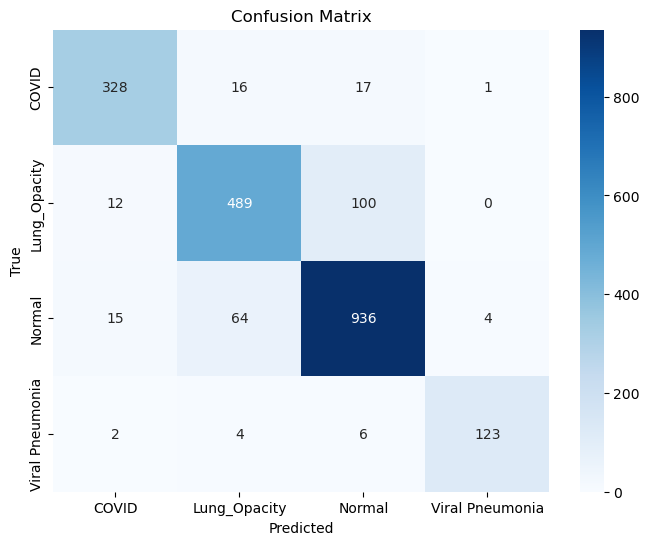

In [80]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Ploting training progress**

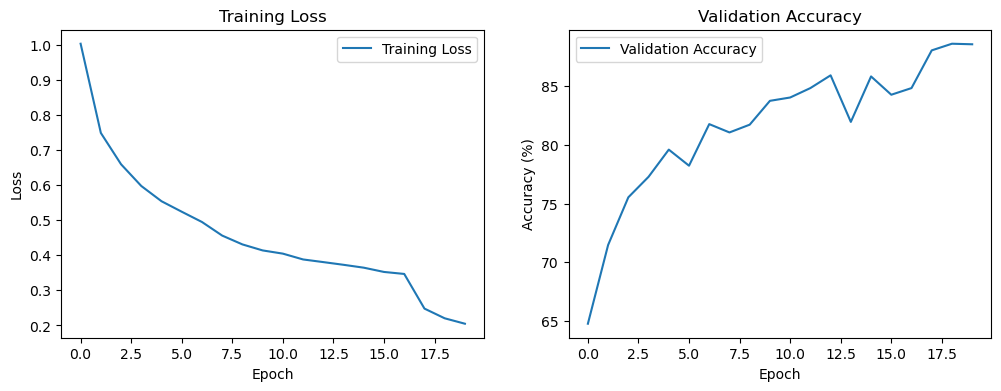

In [82]:
# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()